You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from NGD_TK_AS import NGD2L_TK_AS
from NGD_TK_AS import ParaTrans

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from NGD_TK_AS.ipynb


# Load Experimental data

## select files and channels

In [3]:
cn = 53

NGD2L1DASpara = np.load( 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGD2LASpara.npz', allow_pickle=True)
for k in NGD2L1DASpara.files:
    vars()[k] = NGD2L1DASpara[k][()]

pd.DataFrame(para_dict).loc[cn-1]

epsilon         14.217523
gamma        73996.448279
omegastar       44.711774
deltastar        0.285205
tau_y            0.071035
Dmp             17.541824
error            0.093686
Name: 52, dtype: float64

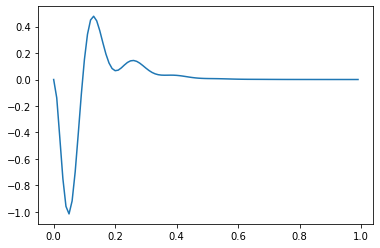

In [4]:
dt = 0.01
T = np.arange(0, 1., dt)
plt.plot(T, NGD2L_TK_AS(T, *pd.DataFrame(para_dict).loc[cn-1][:-1]))

In [5]:
Fc_list = [2]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]


x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][cn-1,:]

In [6]:
Dt = 0.01
v_list = [np.append(np.zeros(int(Dt/dt)), x[int(Dt/dt):]-x[:-int(Dt/dt)])/Dt  for x in x_list]
tv_list = [np.append(0, np.diff(x))/dt  for x in x_list]

In [7]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3)) 
t_cor_list

[0.534]

In [8]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

# Real Spike

## Plot MI

In [9]:
window = [-1,1] # second
Real_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Real_Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = Real_Information_list.copy()

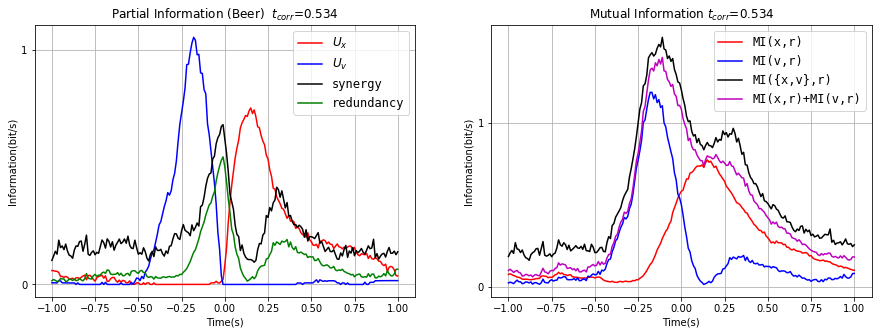

In [10]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

# Fake Spike - LC model

## parameters for LC model and Spike Generator

In [11]:
#Assign states
r1state_list = []
ystate_list = [0]*len(x_list)
# Delta_list = [0.4, 0.3, 0.26, 0.24]
# Delta_list = [.9, .9, .9, .9]
FakeSpike_list = [0]*len(x_list)
for i in range(len(x_list)):
    Lambda = 0.45
    r1 = (1-Lambda)*x_list[i]+Lambda*v_list[i]

    r = NL(r1-np.mean(r1), 0)
    ratio = sum(r)/T_list[i][-1]/2
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))

## Plot MI

In [12]:
window = [-1,1] # second
LC_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, LC_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
Information_list = LC_Information_list.copy()

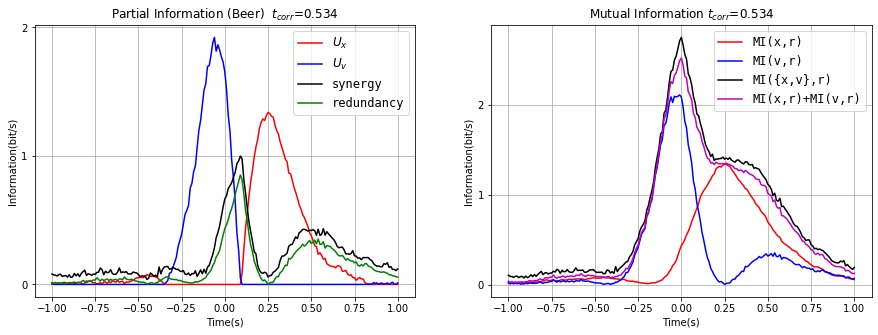

In [13]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

# Fake Spike - NGD0D

## parameters for NGD model and Spike generator

In [37]:
# following paremeters match x+v*0.5s
alpha = 20. #1/sec
beta =  1.2
K = 23.
g = 40.
phi = 1

# alpha  =   27.569117
# beta   =    0.669362
# K      = 17
# phi    = 1/17
# g      = 2173.272324
# tau_y  =    0.071362


y_list = []
for i in range(len(x_list)):
    x = x_list[i].copy()
    #---------------------------------------------
    ds = 10
    x = np.repeat(x,ds)
    sdt = dt/ds
    y=np.zeros(len(x))
    z=np.zeros(len(x))
    for j in range(len(x)-1):
        dy=sdt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=sdt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    y_list.append(y[::ds])
    #---------------------------------------------
# y1_list = y_list.copy()

(150, 160)

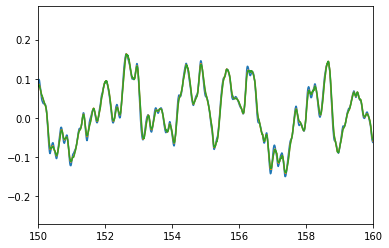

In [29]:
for ds in [1,5,50]:
    y_list = []
    for i in range(len(x_list)):
        x = x_list[i].copy()
        #---------------------------------------------
#         ds = 100
        x = np.repeat(x,ds)
        sdt = dt/ds
        T = np.arange(len(x))*sdt
        y=np.zeros(len(x))
        z=np.zeros(len(x))
        for j in range(len(x)-1):
            dy=sdt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
            dz=sdt*(-beta*z[j]+g*y[j])
            y[j+1]=y[j]+dy
            z[j+1]=z[j]+dz
        plt.plot(T,y)
plt.xlim([150, 160])

(150, 160)

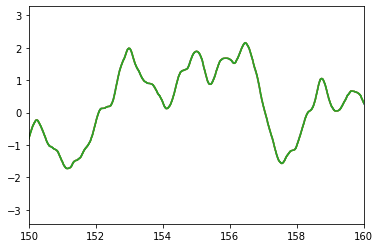

In [30]:
for ds in [1,5,50]:
    y_list = []
    for i in range(len(x_list)):
        x = x_list[i].copy()
        #---------------------------------------------
#         ds = 100
        xnew = np.repeat(x,ds)
        sdt = dt/ds
        T = np.arange(len(x))*sdt
#         y=np.zeros(len(x))
#         z=np.zeros(len(x))
#         for j in range(len(x)-1):
#             dy=sdt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
#             dz=sdt*(-beta*z[j]+g*y[j])
#             y[j+1]=y[j]+dy
#             z[j+1]=z[j]+dz
        plt.plot(T,x)
plt.xlim([150, 160])

(150, 160)

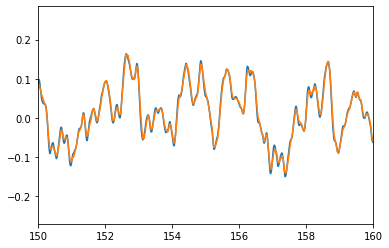

In [44]:
for i in range(len(x_list)):
    x = x_list[i].copy()
    T = np.arange(len(x))*dt
    y=np.zeros(len(x))
    z=np.zeros(len(x))
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    plt.plot(T,y)
    
for i in range(len(x_list)):
    x = x_list[i].copy()
    #---------------------------------------------
    ds = 10
    xnew = np.repeat(x,ds)
    sdt = dt/ds
    Tnew = np.arange(len(xnew))*sdt
    ynew =np.zeros(len(xnew))
    znew =np.zeros(len(xnew))
    for j in range(len(xnew)-1):
        dy=sdt*(-alpha*ynew[j]+K*(xnew[j]-phi*znew[j]))
        dz=sdt*(-beta*znew[j]+g*ynew[j])
        ynew[j+1]=ynew[j]+dy
        znew[j+1]=znew[j]+dz
    plt.plot(Tnew,ynew)
plt.xlim([150, 160])

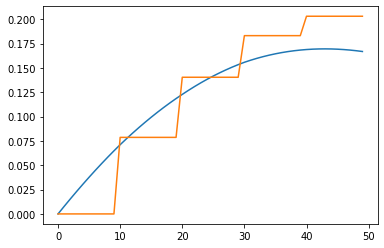

In [49]:
plt.plot(ynew[:50])
plt.plot(np.repeat(y[:5],ds))

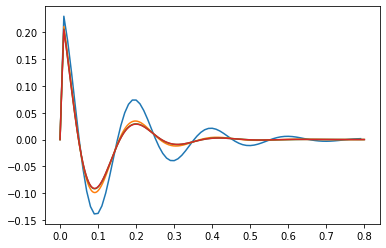

In [51]:
for ds in [1,5,50,500]:
    y_list = []
    for i in range(len(x_list)):

    #---------------------------------------------
#         ds = 100
        sdt = dt/ds
#         x = np.zeros(int(0.8/sdt))
#         x[0] =1/sdt
        x = np.zeros(int(0.8/dt))
        x[0] = 1
        x = np.repeat(x,ds)
        T = np.arange(len(x))*sdt

        y=np.zeros(len(x))
        z=np.zeros(len(x))
        for j in range(len(x)-1):
            dy=sdt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
            dz=sdt*(-beta*z[j]+g*y[j])
            y[j+1]=y[j]+dy
            z[j+1]=z[j]+dz
        plt.plot(T,y)
# plt.xlim([0, 5*dt])

(15000, 16000)

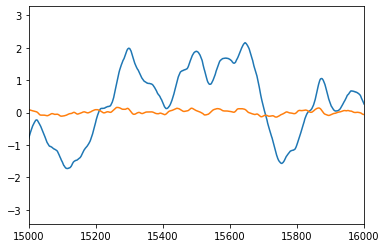

In [15]:
plt.plot(x_list[0])
plt.plot(y_list[0])
plt.xlim([15000, 16000])

Assign states

In [16]:
FakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
time_ystate_list = [0]*len(x_list)
order = np.arange(len(x_list))
np.random.shuffle(order)
print(order)
ratio, theta = 0, 0
for i in order:
    y = y_list[i].copy()
    r = NL(-y+np.mean(y), 0)
    ratio = sum(r)/T_list[i][-1]/2
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     theta = 1.5*np.std(y) if theta == 0 else theta
#     r = NL(np.mean(y)-y, theta)
#     ratio = sum(r)/sum(rstate_list[i]) if ratio == 0 else ratio
#     FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
#     print(len(FakeSpike_list[i])/sum(rstate_list[i]), len(FakeSpike_list[i])/len(r1))
#     ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     Spike = np.hstack((0, FakeSpike_list[i], T_list[i][-1]))
#     counter = 0
#     ty = np.zeros_like(y)
#     for k in range(len(ystate_list[i])):
#         counter += ystate_list[i][k]
#         ty[k] = (Spike[counter+1]-Spike[counter-ystate_list[i][k]])/(ystate_list[i][k]+1)
#     time_ystate_list[i], _ = EqualState(ty, 6)

[0]


## Plot MI

In [17]:
window = [-1,1] # second
NGD_Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, NGD_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = NGD_Information_list.copy()

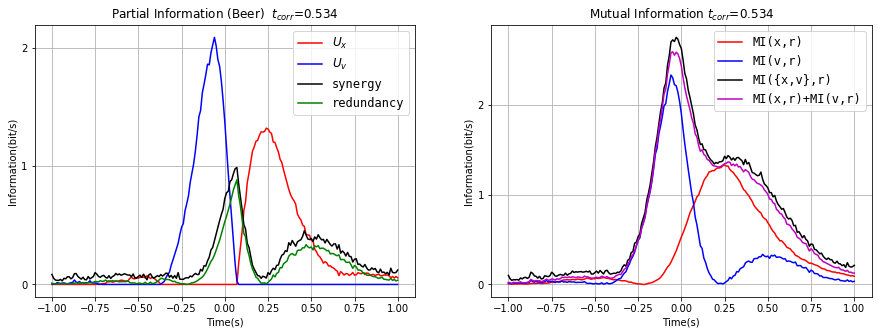

In [18]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)